In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [78]:
import os
from PIL import Image
import glob
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms  as tt
import torchvision.models as models
from numpy import asarray
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision import transforms
from PIL import Image
from torchvision.datasets import ImageFolder
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device =torch.device('cpu' if torch.cuda.is_available() else 'cuda')

In [79]:
# Device we currently use

device

device(type='cuda')

In [80]:
# Creating train and validation data set

train_set = os.listdir(r'../input/chest-xray-pneumonia/chest_xray/train')
val_set = os.listdir(r'../input/chest-xray-pneumonia/chest_xray/val')
#classes = os.listdir(r'../input/chest-xray-pneumonia/chest_xray/train')

In [81]:
# Sample pic 

#image = Image.open('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
#image

In [82]:
# Data transforms (normalization & data augmentation) 
# In this code normanlization is not using

#stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_tfms = tt.Compose([#tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.Resize((128,128)),
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(),
                         tt.RandomErasing(inplace=True),])
                         #tt.Normalize(*stats,inplace=True)
valid_tfms = tt.Compose([tt.Resize((128,128)),tt.ToTensor()]) #tt.Normalize(*stats)
test_tfms = tt.Compose ([tt.Resize((128,128)),tt.ToTensor()])

In [83]:
# Creating dataset changes

train_ds = ImageFolder(r'../input/chest-xray-pneumonia/chest_xray/train', train_tfms)
val_ds = ImageFolder(r'../input/chest-xray-pneumonia/chest_xray/val',valid_tfms)       # ImageFolder is used to combine_
test_ds = ImageFolder(r'../input/chest-xray-pneumonia/chest_xray/test',test_tfms)                           # _all catagories into one dataset
img,label =val_ds[0]
img.shape                                                                                                       

torch.Size([3, 128, 128])

In [84]:
# Creating DataLoader

batch_size = 400 #  <=500 
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds,batch_size*2,shuffle=True,num_workers=3,pin_memory=True)

(torch.Size([3, 128, 128]), 0)

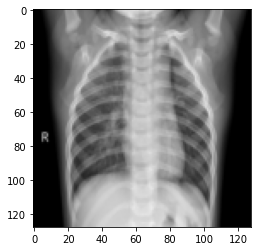

In [85]:
# Sample
# RandomErasing is using 

img,label= train_ds[263]
plt.imshow(img.permute(1,2,0))
img.shape,label

In [86]:
# To stable randomization 

random_seed =20
torch.manual_seed(random_seed)

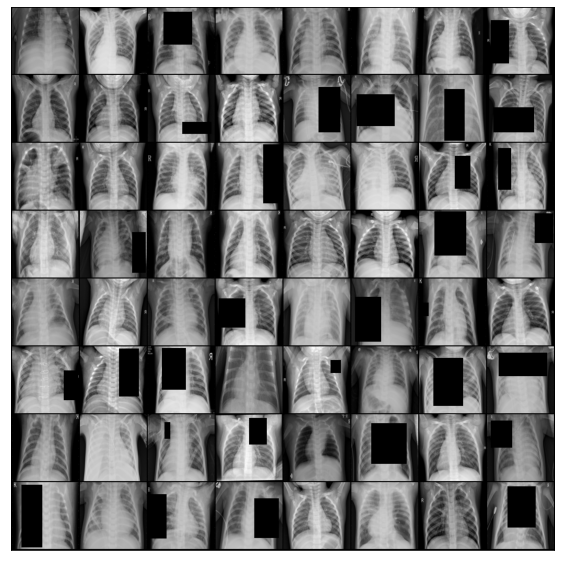

In [87]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_dl)


In [88]:
# Creating a data _loader from Cpu to Cuda
def to_device(data,device):
    if isinstance (data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x,self.device)
    def __len__(self):
        return len(self.dl)

In [89]:
# CPU to CUDA

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
#test_set = DeviceDataLoader(test_set, device)


In [90]:
# Creating Model

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))   

class IC(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        #out = out.argmax(dim=1)
        loss = F.cross_entropy(out, labels) # Calculate loss  , Use ......Binary_Cross_Entropy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)# Generate predictions
        #out = out.argmax(dim=1)
        loss = F.cross_entropy(out, labels)   # Calculate loss , Use ......Binary_Cross_Entropy
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))      

In [91]:
class CNN(IC):
    def __init__(self):
        super().__init__()
        # Used a pretrained Model
        self.network = models.resnet18(pretrained=True) # Resnet 18
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(nn.BatchNorm1d(num_ftrs),
                                        nn.Linear(num_ftrs,512),
                                        nn.ReLU(),   # Activation function , for non_linearity
                                        nn.Dropout(.5),  # to drop some values              
                                        nn.Linear(512,512),# Linear layer
                                        nn.ReLU(),
                                        nn.Linear(512,2))
        
            
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb)) 
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False                               # To freeze the residual layers
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        for param in self.network.parameters():                      # Unfreeze all layers
            param.require_grad = True

In [92]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)          # >>> Set up custom optimizer with weight decay
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,        # >>> Set up one-cycle learning rate scheduler
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            #lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [93]:
gc.collect()                                # Clearing GPU memory
torch.cuda.empty_cache()

In [94]:
model = to_device(CNN(), device)  # model to device

In [95]:
# RE-check
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [96]:
history = evaluate(model,val_dl)
history
#type(history)

{'val_loss': 0.6939221620559692, 'val_acc': 0.5625}

In [97]:
model.freeze()

In [98]:
max_lr= 0.001
weight_decay = 1e-4
grad_clip = 0.1
a=1
history = fit_one_cycle(a, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay)

Epoch [0],train_loss: 0.4590, val_loss: 0.6498, val_acc: 0.6250


In [99]:
%%time
epoch = 5
max_lr= 0.001
weight_decay = 1e-6
grad_clip = 0.1

history += fit_one_cycle(epoch, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay) 

Epoch [0],train_loss: 0.3363, val_loss: 0.8133, val_acc: 0.5000
Epoch [1],train_loss: 0.3561, val_loss: 0.5497, val_acc: 0.7500
Epoch [2],train_loss: 0.3742, val_loss: 0.7831, val_acc: 0.5000
Epoch [3],train_loss: 0.3390, val_loss: 0.4484, val_acc: 0.8750
Epoch [4],train_loss: 0.3397, val_loss: 0.5109, val_acc: 0.8125
CPU times: user 5.54 s, sys: 4.04 s, total: 9.58 s
Wall time: 9min 49s


In [100]:
%%time
model.unfreeze()
epoch = 5
max_lr1= 0.0001
weight_decay = 1e-4
grad_clip = 0.001

history += fit_one_cycle(epoch,max_lr1, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay)

Epoch [0],train_loss: 0.3371, val_loss: 0.5558, val_acc: 0.7500
Epoch [1],train_loss: 0.3355, val_loss: 0.6376, val_acc: 0.6875
Epoch [2],train_loss: 0.3320, val_loss: 0.6921, val_acc: 0.5625
Epoch [3],train_loss: 0.3283, val_loss: 0.5797, val_acc: 0.7500
Epoch [4],train_loss: 0.3289, val_loss: 0.5502, val_acc: 0.7500
CPU times: user 5.39 s, sys: 3.89 s, total: 9.28 s
Wall time: 9min 46s


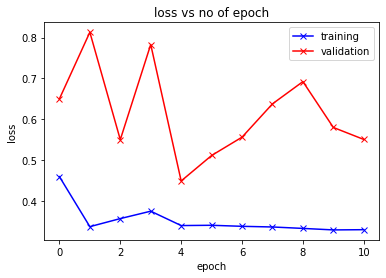

In [101]:
def plot_loss(history=history):
    train_loss = [x.get('train_loss') for x in history]
    val_loss = [x['val_loss'] for x in history]
    plt.plot(train_loss,'-bx')
    plt.plot(val_loss,'-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training','validation'])
    plt.title('loss vs no of epoch')
plot_loss()
    

label: PNEUMONIA predicted: PNEUMONIA


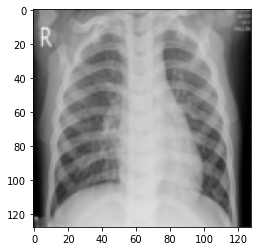

In [105]:
def predict_img(img,model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _,pred = torch.max(yb,dim=1)
    return train_ds.classes[pred[0].item()]
img,label = test_ds[422]
plt.imshow(img.permute(1,2,0))
print('label:',train_ds.classes[label],'predicted:',predict_img(img,model))


In [106]:
torch.save(model.state_dict(),'chest-xray-pneumonia.pth')

In [ ]:
model.state_dict()